<a href="https://colab.research.google.com/github/HARDIK218/GenAI-VAE/blob/main/new_sanskrit_transliteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
 # weight initialization
 init = RandomNormal(stddev=0.02)
 # source image input
 in_src_image = Input(shape=image_shape)
 # target image input
 in_target_image = Input(shape=image_shape)
 # concatenate images channel-wise
 merged = Concatenate()([in_src_image, in_target_image])
 # C64
 d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
 d = LeakyReLU(alpha=0.2)(d)
 # C128
 d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # C256
 d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # C512
 d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # second last output layer
 d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # patch output
 d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
 patch_out = Activation('sigmoid')(d)
 # define model
 model = Model([in_src_image, in_target_image], patch_out)
 # compile model
 opt = Adam(lr=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
 return model

In [ ]:
# define an encoder block
from keras.initializers import RandomNormal
from keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Concatenate, Activation
from keras.models import Model

def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# define the standalone generator model
def define_generator(image_shape=(256, 256, 3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model


In [ ]:
# define the combined generator and discriminator model, for updating the generator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False

    # define the source image
    in_src = Input(shape=image_shape)

    # connect the source image to the generator input
    gen_out = g_model(in_src)

    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])

    # src image as input, generated image, and classification output
    model = Model(in_src, [dis_out, gen_out])

    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1, 100])

    return model


In [ ]:
# load and prepare training images
def load_real_samples(filename):
 # load compressed arrays
 data = load(filename)
 # unpack arrays
 X1, X2 = data['arr_0'], data['arr_1']
 # scale from [0,255] to [-1,1]
 X1 = (X1 - 127.5) / 127.5
 X2 = (X2 - 127.5) / 127.5
 return [X1, X2]

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
 # unpack dataset
 trainA, trainB = dataset
 # choose random instances
 ix = randint(0, trainA.shape[0], n_samples)
 # retrieve selected images
 X1, X2 = trainA[ix], trainB[ix]
 # generate 'real' class labels (1)
 y = ones((n_samples, patch_shape, patch_shape, 1))
 return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
 # generate fake instance
 X = g_model.predict(samples)
 # create 'fake' class labels (0)
 y = zeros((len(X), patch_shape, patch_shape, 1))

 return X,y

In [ ]:
from matplotlib import pyplot as plt

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])

    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])

    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])

    # save plot to file
    filename1 = 'plot_%06d.png' % (step + 1)
    plt.savefig(filename1)
    plt.close()

    # save the generator model
    filename2 = 'model_%06d.h5' % (step + 1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))


In [ ]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]

    # unpack dataset
    trainA, trainB = dataset

    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)

    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs

    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)

        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)

        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))

        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)  # Corrected indentation here


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from os import listdir
from numpy import asarray,load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot

import numpy as np

In [ ]:
from keras.preprocessing.image import img_to_array, load_img
from os import listdir
from numpy import asarray

def load_images(path, size=(256, 512)):
    src_list, tar_list = list(), list()
    for filename in listdir(path):
        # Load and resize the image
        pixels = load_img(os.path.join(path, filename), target_size=size)
        # Convert to numpy array
        pixels = img_to_array(pixels)
        # Split into satellite and map
        sat_img, map_img = pixels[:, :256], pixels[:, 256:]
        src_list.append(sat_img)
        tar_list.append(map_img)
    return [asarray(src_list), asarray(tar_list)]

import os

# Define the path to the 'train' directory
train_directory = '/content/drive/MyDrive/Nandiagari Dataset_latest'

# Function to get file paths of images in a directory
def get_image_paths_from_directory(directory, extension=".png"):
    image_paths = []
    for filename in os.listdir(directory):
        if filename.endswith(extension):
            image_path = os.path.join(directory, filename)
            image_paths.append(image_path)
    return image_paths

train_image_paths = get_image_paths_from_directory(train_directory)

loaded_images = load_images(train_directory)  # Load and process images

src_images = loaded_images[0]  # hand written
tar_images = loaded_images[1]  # typed


num_images = len(src_images)
print('Loaded:', num_images, 'images')


Loaded: 294 images


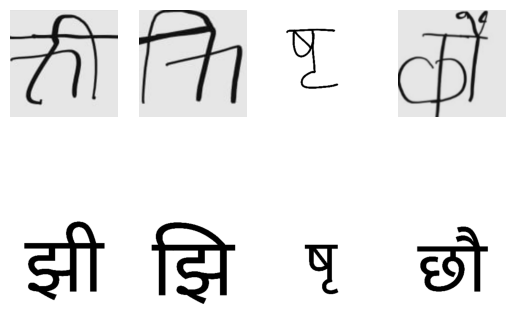

In [ ]:
n_samples = 4
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [ ]:
#implementation of GAN
#define input shape on the loaded dataset
image_shape = src_images.shape[1:]
#define the model
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

gan_model = define_gan(g_model,d_model,image_shape)

#Define data
data = [src_images,tar_images]

def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)
from datetime import datetime
start1 = datetime.now()

train(d_model, g_model, gan_model, dataset, n_epochs=80, n_batch=1)

g_model.save('generator_model1.keras')
# Save the generator and discriminator models
g_model.save('generator_model.h5')
d_model.save('discriminator_model.h5')

stop1 = datetime.now()
#Execution time of the model
execution_time = stop1-start1
print("Execution time is: ", execution_time)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 32ms/step
>442, d1[0.007] d2[0.013] g[28.130]
1/1 [==============================] - 0s 27ms/step
>443, d1[0.006] d2[0.013] g[28.248]
1/1 [==============================] - 0s 27ms/step
>444, d1[0.006] d2[0.027] g[29.841]
1/1 [==============================] - 0s 26ms/step
>445, d1[0.007] d2[0.012] g[29.481]
1/1 [==============================] - 0s 26ms/step
>446, d1[0.010] d2[0.012] g[14.641]
1/1 [==============================] - 0s 26ms/step
>447, d1[0.007] d2[0.012] g[25.192]
1/1 [==============================] - 0s 27ms/step
>448, d1[0.007] d2[0.012] g[20.590]
1/1 [==============================] - 0s 26ms/step
>449, d1[0.007] d2[0.012] g[21.003]
1/1 [==============================] - 0s 23ms/step
>450, d1[0.008] d2[0.012] g[16.978]
1/1 [==============================] - 0s 25ms/step
>451, d1[0.006] d2[0.012] g[22.285]
1/1 [==============================] - 0s 27ms/step
>452, d1[0.005] d

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
>3382, d1[0.072] d2[0.057] g[17.883]
1/1 [==============================] - 0s 21ms/step
>3383, d1[0.060] d2[0.057] g[18.828]
1/1 [==============================] - 0s 25ms/step
>3384, d1[0.036] d2[0.058] g[25.478]
1/1 [==============================] - 0s 24ms/step
>3385, d1[0.042] d2[0.071] g[19.428]
1/1 [==============================] - 0s 25ms/step
>3386, d1[0.028] d2[0.063] g[26.038]
1/1 [==============================] - 0s 24ms/step
>3387, d1[0.030] d2[0.055] g[35.301]
1/1 [==============================] - 0s 26ms/step
>3388, d1[0.031] d2[0.064] g[20.666]
1/1 [==============================] - 0s 25ms/step
>3389, d1[0.036] d2[0.058] g[19.140]
1/1 [==============================] - 0s 21ms/step
>3390, d1[0.026] d2[0.057] g[30.664]
1/1 [==============================] - 0s 19ms/step
>3391, d1[0.047] d2[0.082] g[16.421]
1/1 [==============================] - 0s 21ms/step
>3392, 

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
>6322, d1[0.060] d2[0.103] g[22.469]
1/1 [==============================] - 0s 30ms/step
>6323, d1[0.085] d2[0.221] g[16.015]
1/1 [==============================] - 0s 30ms/step
>6324, d1[0.104] d2[0.127] g[19.667]
1/1 [==============================] - 0s 27ms/step
>6325, d1[0.044] d2[0.105] g[23.715]
1/1 [==============================] - 0s 27ms/step
>6326, d1[0.090] d2[0.095] g[17.292]
1/1 [==============================] - 0s 37ms/step
>6327, d1[0.034] d2[0.172] g[20.071]
1/1 [==============================] - 0s 26ms/step
>6328, d1[0.566] d2[0.218] g[13.049]
1/1 [==============================] - 0s 21ms/step
>6329, d1[0.025] d2[1.071] g[15.856]
1/1 [==============================] - 0s 20ms/step
>6330, d1[0.096] d2[0.102] g[24.505]
1/1 [==============================] - 0s 26ms/step
>6331, d1[0.695] d2[0.160] g[19.106]
1/1 [==============================] - 0s 23ms/step
>6332, 

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
>9262, d1[0.493] d2[0.276] g[6.118]
1/1 [==============================] - 0s 27ms/step
>9263, d1[0.212] d2[0.425] g[12.481]
1/1 [==============================] - 0s 30ms/step
>9264, d1[0.331] d2[0.247] g[12.211]
1/1 [==============================] - 0s 27ms/step
>9265, d1[0.224] d2[0.334] g[14.581]
1/1 [==============================] - 0s 31ms/step
>9266, d1[0.211] d2[0.292] g[17.968]
1/1 [==============================] - 0s 27ms/step
>9267, d1[0.620] d2[0.295] g[5.221]
1/1 [==============================] - 0s 30ms/step
>9268, d1[0.585] d2[0.232] g[14.457]
1/1 [==============================] - 0s 26ms/step
>9269, d1[0.116] d2[0.497] g[17.396]
1/1 [==============================] - 0s 27ms/step
>9270, d1[0.216] d2[0.501] g[10.323]
1/1 [==============================] - 0s 29ms/step
>9271, d1[0.311] d2[0.441] g[7.194]
1/1 [==============================] - 0s 28ms/step
>9272, d1[

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
>12202, d1[0.364] d2[0.370] g[12.517]
1/1 [==============================] - 0s 23ms/step
>12203, d1[0.380] d2[0.365] g[6.155]
1/1 [==============================] - 0s 29ms/step
>12204, d1[0.363] d2[0.379] g[5.313]
1/1 [==============================] - 0s 25ms/step
>12205, d1[0.366] d2[0.370] g[11.458]
1/1 [==============================] - 0s 28ms/step
>12206, d1[0.353] d2[0.390] g[4.992]
1/1 [==============================] - 0s 26ms/step
>12207, d1[0.381] d2[0.362] g[9.362]
1/1 [==============================] - 0s 32ms/step
>12208, d1[0.370] d2[0.373] g[6.968]
1/1 [==============================] - 0s 31ms/step
>12209, d1[0.367] d2[0.368] g[6.863]
1/1 [==============================] - 0s 30ms/step
>12210, d1[0.369] d2[0.374] g[4.825]
1/1 [==============================] - 0s 29ms/step
>12211, d1[0.369] d2[0.372] g[5.204]
1/1 [==============================] - 0s 28ms/step
>1221

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
>15142, d1[0.359] d2[0.371] g[4.125]
1/1 [==============================] - 0s 33ms/step
>15143, d1[0.358] d2[0.372] g[4.297]
1/1 [==============================] - 0s 22ms/step
>15144, d1[0.359] d2[0.371] g[3.772]
1/1 [==============================] - 0s 27ms/step
>15145, d1[0.358] d2[0.371] g[6.185]
1/1 [==============================] - 0s 31ms/step
>15146, d1[0.357] d2[0.371] g[8.935]
1/1 [==============================] - 0s 38ms/step
>15147, d1[0.359] d2[0.370] g[5.265]
1/1 [==============================] - 0s 24ms/step
>15148, d1[0.358] d2[0.372] g[4.269]
1/1 [==============================] - 0s 29ms/step
>15149, d1[0.361] d2[0.370] g[3.162]
1/1 [==============================] - 0s 23ms/step
>15150, d1[0.358] d2[0.372] g[6.298]
1/1 [==============================] - 0s 29ms/step
>15151, d1[0.361] d2[0.370] g[3.870]
1/1 [==============================] - 0s 28ms/step
>15152,

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step
>18082, d1[0.361] d2[0.374] g[1.939]
1/1 [==============================] - 0s 21ms/step
>18083, d1[0.361] d2[0.374] g[2.208]
1/1 [==============================] - 0s 32ms/step
>18084, d1[0.362] d2[0.374] g[2.910]
1/1 [==============================] - 0s 20ms/step
>18085, d1[0.361] d2[0.374] g[4.817]
1/1 [==============================] - 0s 20ms/step
>18086, d1[0.360] d2[0.374] g[4.564]
1/1 [==============================] - 0s 27ms/step
>18087, d1[0.360] d2[0.375] g[8.328]
1/1 [==============================] - 0s 26ms/step
>18088, d1[0.360] d2[0.375] g[3.179]
1/1 [==============================] - 0s 21ms/step
>18089, d1[0.360] d2[0.375] g[5.276]
1/1 [==============================] - 0s 26ms/step
>18090, d1[0.360] d2[0.374] g[1.954]
1/1 [==============================] - 0s 29ms/step
>18091, d1[0.361] d2[0.374] g[2.899]
1/1 [==============================] - 0s 33ms/step
>18092,

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step
>21022, d1[0.371] d2[0.380] g[4.319]
1/1 [==============================] - 0s 31ms/step
>21023, d1[0.371] d2[0.380] g[1.919]
1/1 [==============================] - 0s 20ms/step
>21024, d1[0.371] d2[0.381] g[2.061]
1/1 [==============================] - 0s 23ms/step
>21025, d1[0.372] d2[0.381] g[5.186]
1/1 [==============================] - 0s 45ms/step
>21026, d1[0.372] d2[0.380] g[2.281]
1/1 [==============================] - 0s 28ms/step
>21027, d1[0.371] d2[0.379] g[1.862]
1/1 [==============================] - 0s 28ms/step
>21028, d1[0.371] d2[0.379] g[2.406]
1/1 [==============================] - 0s 33ms/step
>21029, d1[0.371] d2[0.380] g[3.454]
1/1 [==============================] - 0s 29ms/step
>21030, d1[0.371] d2[0.379] g[3.352]
1/1 [==============================] - 0s 33ms/step
>21031, d1[0.371] d2[0.379] g[2.127]
1/1 [==============================] - 0s 29ms/step
>21032,

>Saved: plot_023520.png and model_023520.h5


Execution time is:  1:36:54.459575


In [ ]:
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from numpy import expand_dims
from matplotlib import pyplot as plt

# Function to load and prepare an image
def load_image(filename, size=(256, 256)):
    # Load the image with the required size
    pixels = load_img(filename, target_size=size)
    # Convert to numpy array
    pixels = img_to_array(pixels)
    # Scale pixel values to the range [0,1]
    pixels = pixels / 255.0
    # Add a batch dimension
    pixels = expand_dims(pixels, 0)
    return pixels

# Function to generate fake image using the generator model
def generate_fake_image(model, input_image):
    return model.predict(input_image)

# Load the generator model with custom_objects parameter
g_model = load_model('generator_model1.keras', compile=False)

# Compile the generator model
g_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Load and prepare your input image
input_image = load_image('/content/Screenshot 2024-01-24 at 7.34.11 PM.png')

# Generate a fake image using the trained generator
fake_image = generate_fake_image(g_model, input_image)

# Plot the input and generated images
plt.subplot(1, 2, 1)
plt.imshow(array_to_img(input_image[0]))
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(array_to_img(fake_image[0]))
plt.title('Generated Image')

plt.show()